In [1]:
from tqdm import tqdm
import pandas as pd
import cv2
import os

from pathlib import Path
from pandas import DataFrame
from typing import Callable

from common.deblurrers import Deblurrer
from common.config import BLUR_PARAM_RANGES, TEST_BLURRED_DIR
from common.blurrer import gen_box_kernel, gen_gaussian_kernel, gen_motion_kernel

def deblur(
        deblurrer: Deblurrer,
        input_path: Path, 
        output_path: Path, 
        kernel_df: DataFrame = None,
        gen_kernel: Callable = None,
        sample: int = None,
        description: str = ""
    ):
    os.makedirs(output_path, exist_ok=True)

    images_paths = [input_path]
    if not input_path.is_file():
        images_paths = sorted(list(input_path.glob("*.png")))
    if sample and sample >= len(images_paths):
        raise ValueError("sample cannot be greater than number of images")
    if sample:
        images_paths = images_paths[:sample]

    for img_path in tqdm(images_paths, desc=description):
        image = cv2.imread(img_path)
        if image is None:
            print("Could not read the image")
            continue

        img_name = img_path.name
        img_key = img_name.replace('.png', '')

        if kernel_df is not None:
            if not gen_kernel:
                raise ValueError("gen_kernel must be specified when using kernel_df")
            
            # unpack arguments from kernel_df without "key" column
            args = kernel_df.loc[kernel_df["key"] == img_key].drop(columns="key").to_dict(orient="records")[0]
            kernel = gen_kernel(**args)
            deblurred = deblurrer.deblur(image, kernel)
        else:
            deblurred = deblurrer.deblur(image)

        cv2.imwrite(output_path / img_name, deblurred)

def gen_dataset(
        deblurrer: Deblurrer,
        output_path: Path,
        input_path: Path = TEST_BLURRED_DIR,
        kernel_dataset_path: Path = None,
        sample: int = None
    ):

    df = None

    if kernel_dataset_path:
        df = pd.read_parquet(kernel_dataset_path)

    for blur_type, params in BLUR_PARAM_RANGES.items():
        cb = None
        match blur_type:
            case "box":
                cb = gen_box_kernel
            case "gaussian":
                cb = gen_gaussian_kernel
            case "motion":
                cb = gen_motion_kernel

        # convert params to column names
        params = [f"{blur_type}_{el}" for el in params.keys()]

        kernel_df = None
        if df is not None:
            # select key and blur_type parameters, then rename them to correspond to gen_*_kernel arguments 
            kernel_df = df[["key", *params]].rename(
                columns={col: col.replace(f"{blur_type}_", "") for col in params}
            )

        deblur(
            deblurrer=deblurrer,
            input_path=input_path / blur_type,
            output_path=output_path / blur_type,
            kernel_df=kernel_df,
            gen_kernel=cb,
            sample=sample,
            description=f"Deblur: {blur_type:<8}\t",
        )
    

# Generation of the deblurred/


## Pseudo Inverse


In [ ]:
from common.deblurrers import PseudoInverseDeblurrer
from common.config import TEST_DEBLURRED_DIR, IDPA_DATASET

pseudo_deblurrer = PseudoInverseDeblurrer()

# no_kernel generation
gen_dataset(
    deblurrer=pseudo_deblurrer,
    output_path=TEST_DEBLURRED_DIR / f"{pseudo_deblurrer.get_name()}_nokernel",
)

In [ ]:
# w_kernel generation
gen_dataset(
    deblurrer=pseudo_deblurrer,
    output_path=TEST_DEBLURRED_DIR / f"{pseudo_deblurrer.get_name()}_wkernel",
    kernel_dataset_path=IDPA_DATASET,
)

## Wiener


In [ ]:
from common.deblurrers import WienerDeblurrer
from common.config import TEST_DEBLURRED_DIR, IDPA_DATASET

wiener_deblurrer = WienerDeblurrer()

# no_kernel generation
gen_dataset(
    deblurrer=wiener_deblurrer,
    output_path=TEST_DEBLURRED_DIR / f"{wiener_deblurrer.get_name()}_nokernel",
)

In [ ]:
# w_kernel generation
gen_dataset(
    deblurrer=wiener_deblurrer,
    output_path=TEST_DEBLURRED_DIR / f"{wiener_deblurrer.get_name()}_wkernel",
    kernel_dataset_path=IDPA_DATASET,
)

## DeblurGANv2


In [ ]:
from common.deblurrers import DeblurGANv2Deblurrer
from common.config import OFFICIAL_DEBLURGANV2_WEIGHTS, TEST_DEBLURRED_DIR

deblurganv2_deblurrer = DeblurGANv2Deblurrer(
    weights_path=OFFICIAL_DEBLURGANV2_WEIGHTS
)

# no_kernel generation
gen_dataset(
    deblurrer=deblurganv2_deblurrer,
    output_path=TEST_DEBLURRED_DIR / deblurganv2_deblurrer.get_name(),
)

## MPRNet


In [ ]:
from common.deblurrers import MPRNetDeblurrer
from common.config import OFFICIAL_MPRNET_WEIGHTS, TEST_DEBLURRED_DIR

mprnet_deblurrer = MPRNetDeblurrer(
    weights_path=OFFICIAL_MPRNET_WEIGHTS
)

# no_kernel generation
gen_dataset(
    deblurrer=mprnet_deblurrer,
    output_path=TEST_DEBLURRED_DIR / mprnet_deblurrer.get_name(),
)

# Demonstration on one single image


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

from common.config import IDPA_DIR, TEST_BLURRED_DIR, BLUR_PARAM_RANGES, TEST_ORIGINAL_DIR

# types
from pathlib import Path
# from typing import List

img_name = "000000845.png"
temp_dir = IDPA_DIR / ".imgs"

def cp_img(source, destination):
    img = cv2.imread(source)
    cv2.imwrite(destination, img)

# def show(original_path: Path, blurred_path: Path, deblurred_path: List[Path]):
#     for blur_type in BLUR_PARAM_RANGES.keys():
#         image = cv2.imread(original_path)
#         blurred = cv2.imread(blurred_path / blur_type)
#         deblurred = cv2.imread(deblurred_path / blur_type)

def single_deblur(
    deblurrer: Deblurrer,
    output_path: Path,
    img_name: str,
    original_path: Path = TEST_ORIGINAL_DIR / "00000",
    blurred_path: Path = TEST_BLURRED_DIR,
    kernel_dataset_path: Path = None,
):
    os.makedirs(output_path, exist_ok=True)

    kernel_df = None
    if kernel_dataset_path:
        kernel_df = pd.read_parquet(kernel_dataset_path)

    # copy original image to output_path
    cp_img(
        source=original_path / img_name,
        destination=output_path / img_name
    )

    for blur_type in BLUR_PARAM_RANGES.keys():
        deblurrer_name = deblurrer.get_name()
        if kernel_df is not None:
            deblurrer_name = f"{deblurrer.get_name()}_wkernel"

        # get kernel callback
        cb = None
        match blur_type:
            case "box":
                cb = gen_box_kernel
            case "gaussian":
                cb = gen_gaussian_kernel
            case "motion":
                cb = gen_motion_kernel

        # copy blurred images to output_path
        cp_img(
            source=blurred_path / blur_type / img_name, 
            destination=output_path / f"{blur_type}_{img_name}"
        )

        deblur(
            deblurrer=deblurrer,
            input_path=output_path / f"{blur_type}_{img_name}",
            output_path=output_path / deblurrer_name,
            kernel_df=kernel_df,
            gen_kernel=cb,
            description=f"Deblur: {blur_type:<8}\t",
        )
    
    # show images
    for blur_type in BLUR_PARAM_RANGES.keys():
        original = cv2.imread(output_path / img_name)
        blurred = cv2.imread(output_path / f"{blur_type}_{img_name}")
        deblurred = cv2.imread(output_path / deblurrer_name / f"{blur_type}_{img_name}")

        _, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original')
        axes[1].imshow(cv2.cvtColor(deblurred, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Deblurred ({deblurrer_name})')
        axes[2].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f'Blurred ({blur_type})')

        for ax in axes:
            ax.axis('off')
        plt.show()

In [3]:
# import matplotlib.pyplot as plt
# import cv2
# import os

# from common.blurrer import gen_gaussian_kernel, gen_motion_kernel, gen_box_kernel

# def test_filter(deblurrer, image_path: str, save_path: str, provide_kernel: bool = False, save: bool = False):
#     os.makedirs(save_path, exist_ok=True)
#     image = cv2.imread(image_path)
#     if image is None:
#         raise FileNotFoundError(f"Image not found at {image_path}")
    
#     if save:
#         cv2.imwrite(save_path / "original_image.png", image)

#     blur_types = [
#         {'type': 'gaussian', 'size': 15, 'sigma': 3.0},
#         {'type': 'motion', 'size': 15, 'length': 10, 'angle': 45},
#         {'type': 'box', 'size': 5},
#     ]

#     filter_name = deblurrer.get_name()

#     for blur_type in blur_types:
#         if blur_type['type'] == 'gaussian':
#             kernel = gen_gaussian_kernel(blur_type['size'], blur_type['sigma'])
#         elif blur_type['type'] == 'motion':
#             kernel = gen_motion_kernel(blur_type['size'], blur_type['length'], blur_type['angle'])
#         elif blur_type['type'] == 'box':
#             kernel = gen_box_kernel(blur_type['size'])

#         blurred = cv2.filter2D(image, -1, kernel)
#         if save:
#             cv2.imwrite(save_path / f"{filter_name}_{blur_type["type"]}_blurred.png", blurred)
#         if provide_kernel:
#             deblurred_wkernel = deblurrer.deblur(blurred, kernel)
        
#         deblurred = deblurrer.deblur(blurred)

#         if save:
#             cv2.imwrite(save_path / f"{filter_name}_{blur_type["type"]}_deblurred.png", deblurred)

#         if provide_kernel:
#             fig, axes = plt.subplots(1, 4, figsize=(15, 5))

#             axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#             axes[0].set_title('Original')
#             axes[1].imshow(cv2.cvtColor(deblurred_wkernel, cv2.COLOR_BGR2RGB))
#             axes[1].set_title(f'Deblurred {filter_name} wkernel')
#             axes[2].imshow(cv2.cvtColor(deblurred, cv2.COLOR_BGR2RGB))
#             axes[2].set_title(f'Deblurred {filter_name} nokernel')
#             axes[3].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
#             axes[3].set_title(f'Blurred ({blur_type["type"]})')
#         else:
#             fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#             axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#             axes[0].set_title('Original')
#             axes[1].imshow(cv2.cvtColor(deblurred, cv2.COLOR_BGR2RGB))
#             axes[1].set_title(f'Deblurred ({blur_type["type"]}) - {filter_name}')
#             axes[2].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
#             axes[2].set_title(f'Blurred ({blur_type["type"]})')

#         for ax in axes:
#             ax.axis('off')
#         plt.show()

Deblur: motion  	: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


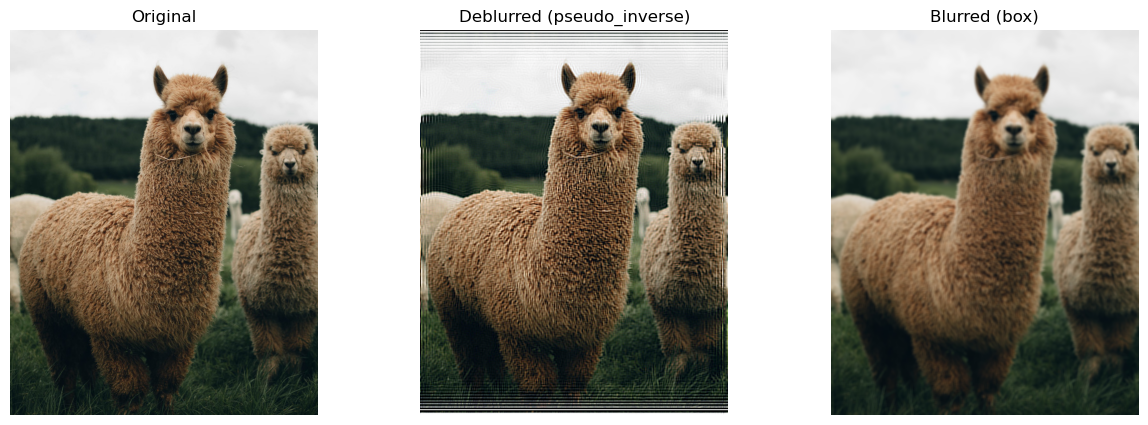

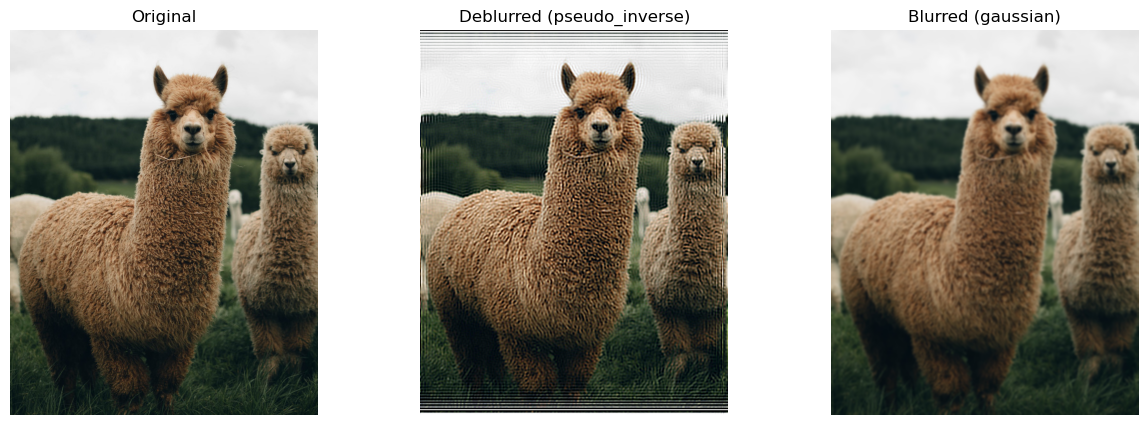

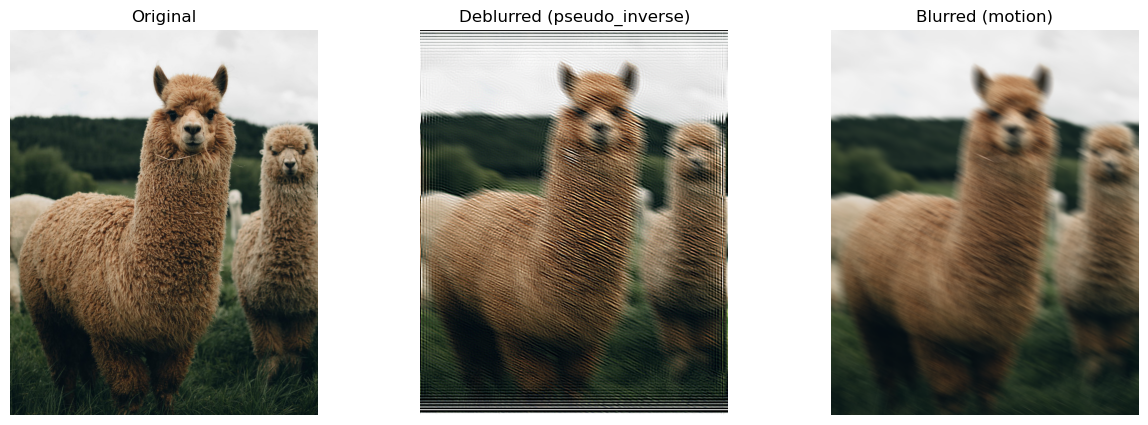

In [4]:
from common.deblurrers import PseudoInverseDeblurrer
from common.config import IDPA_DIR

pseudo_deblurrer = PseudoInverseDeblurrer()
single_deblur(
    deblurrer=pseudo_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png"
)

Deblur: box     	:   0%|          | 0/1 [00:00<?, ?it/s]

Deblur: motion  	: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


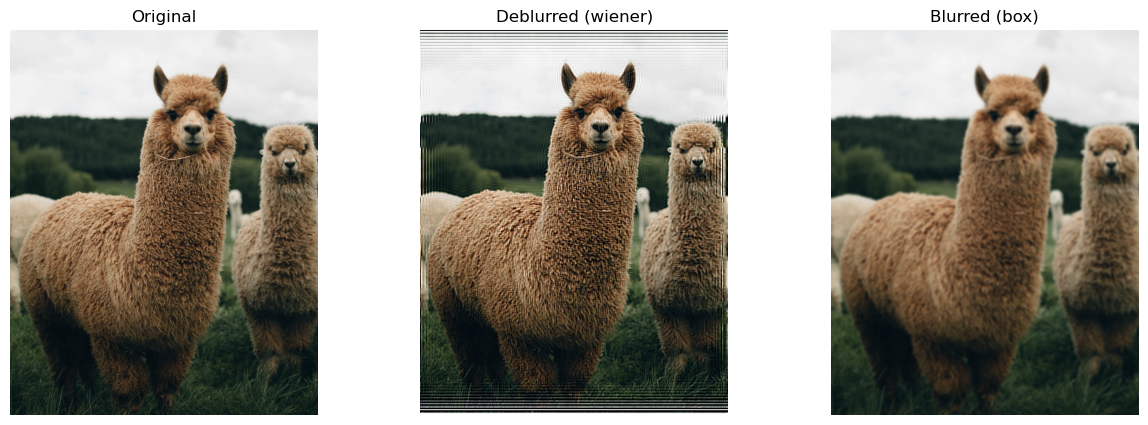

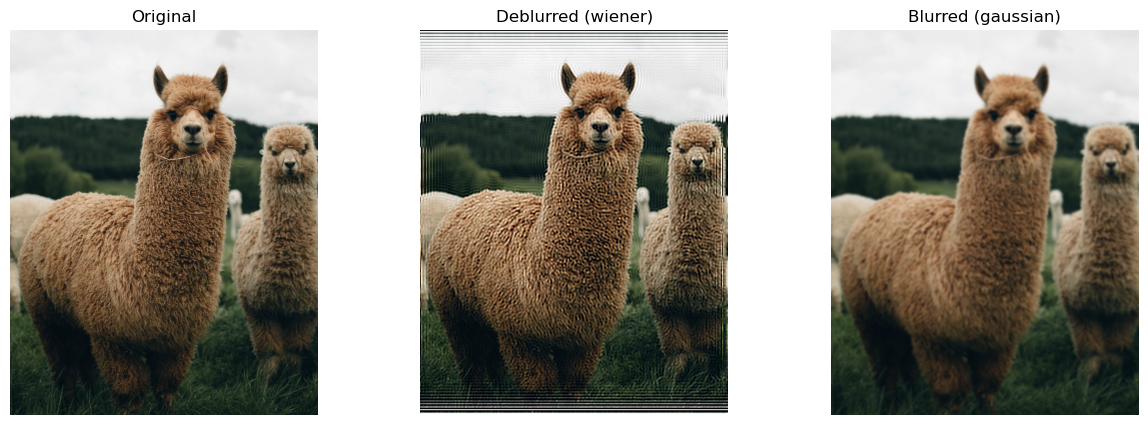

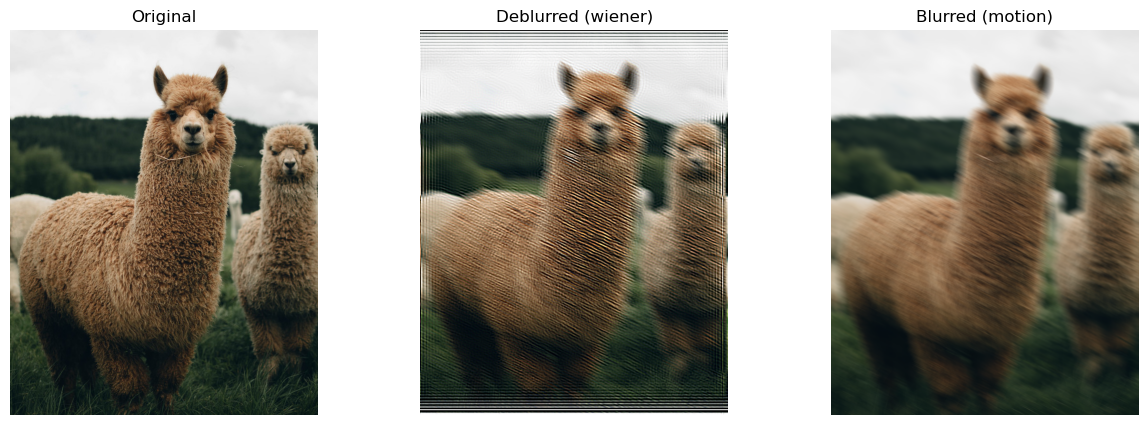

In [5]:
from common.deblurrers import WienerDeblurrer
from common.config import IDPA_DIR

wiener_deblurrer = WienerDeblurrer(K=1e-3)
single_deblur(
    deblurrer=wiener_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png"
)

Deblur: motion  	: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


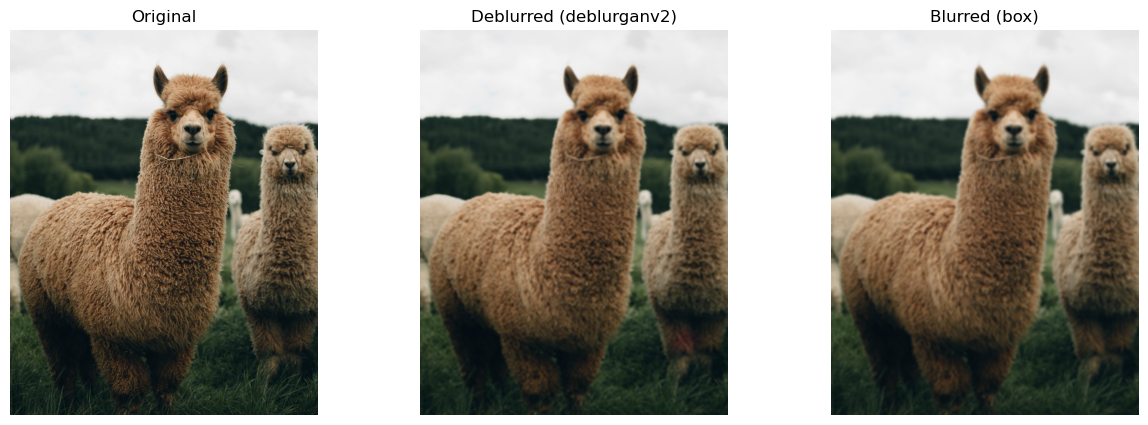

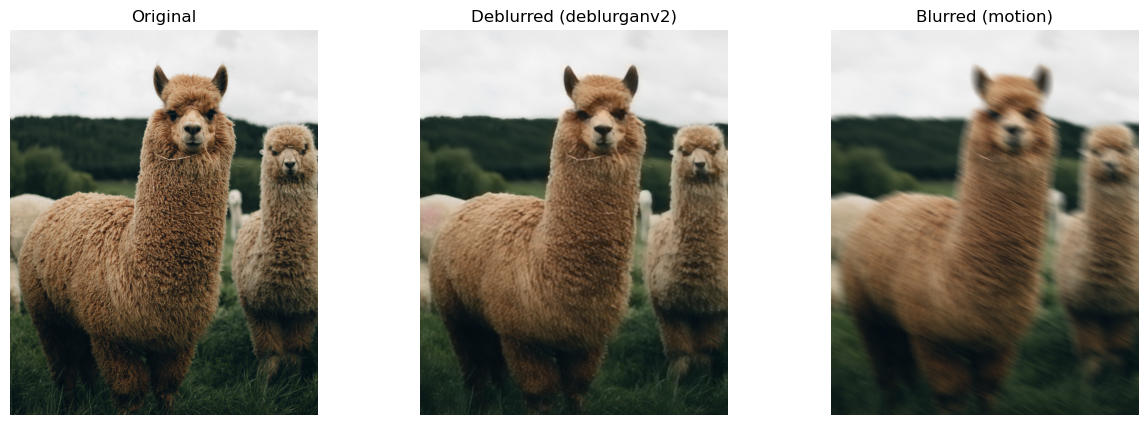

In [6]:
from common.deblurrers import DeblurGANv2Deblurrer
from common.config import OFFICIAL_DEBLURGANV2_WEIGHTS, IDPA_DIR

deblurganv2_deblurrer = DeblurGANv2Deblurrer(
    weights_path=OFFICIAL_DEBLURGANV2_WEIGHTS
)
single_deblur(
    deblurrer=deblurganv2_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png"
)

Deblur: motion  	: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


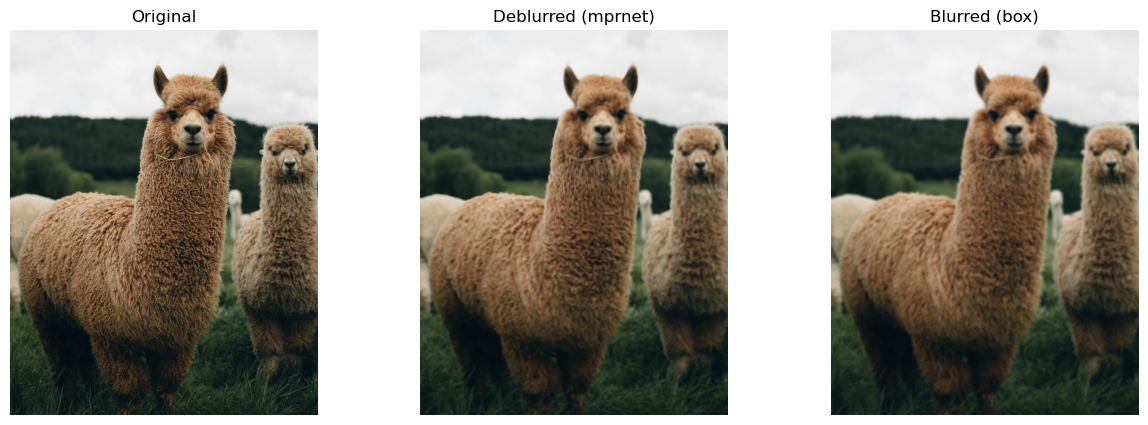

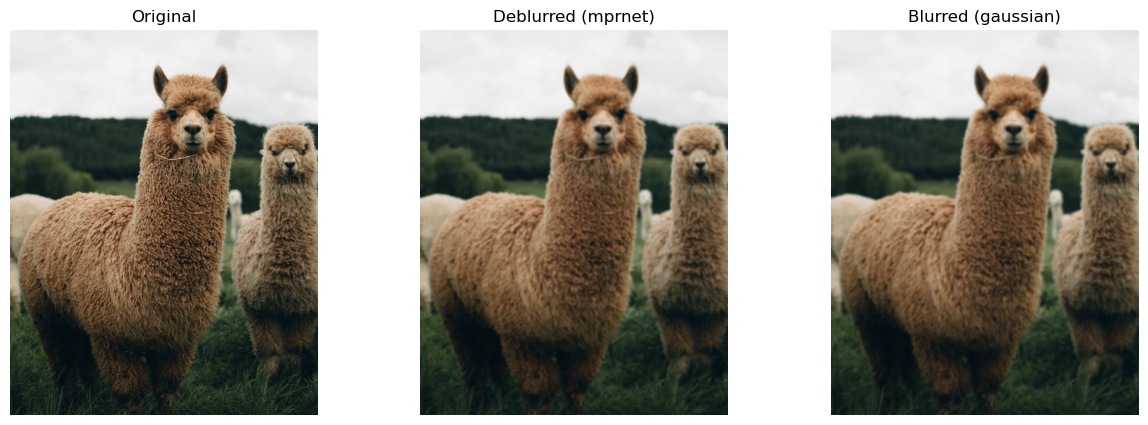

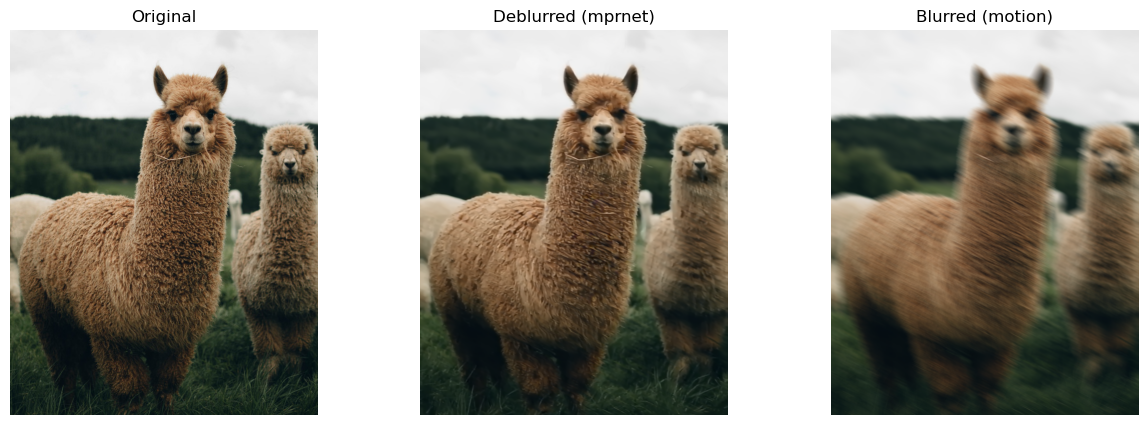

In [7]:
from common.deblurrers import MPRNetDeblurrer
from common.config import OFFICIAL_MPRNET_WEIGHTS, IDPA_DIR

mprnet_deblurrer = MPRNetDeblurrer(
    weights_path=OFFICIAL_MPRNET_WEIGHTS
)
single_deblur(
    deblurrer=mprnet_deblurrer,
    output_path=IDPA_DIR / ".imgs",
    img_name="000000845.png"
)